In [13]:
import time
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Sequential, Input, optimizers
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
CSV_PATH   = "ALL_MERGED.csv"   # <--- set if needed
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

BEST_PARAMS = {
    "lookback": 30,
    "batch_size": 32,
    "epochs": 40,
    "patience": 7,
    "num_layers": 1,
    "units1": 256,
    "dropout": 0.2800299605318308,
    "lr": 0.0013463411932127447,
}

RANDOM_SEED = 31415
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

# ---- UQ settings ---------------------------------------------------------------
ALPHA_CI = 0.05  # 95% PI
REG_LAMBDA = 1e-3  # evidential regularizer strength (tune 1e-4 .. 1e-2 if needed)
ROLL_WIN = 30      # rolling window for rolling-PICP/MPIW plots

In [15]:
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,232.0790,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-02,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,234.9300,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-03,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,240.3580,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-04,13750.0000,62.2000,2136,12980.0000,2090.5100,14467.5000,239.0180,6986.0000,28123.8203,19531.6309,2114.4900,18070.4004,4480.4639,5140.9370
2015-05-05,14245.0000,62.5000,2136,13047.5000,2102.3900,14594.9000,236.1210,6927.6001,27755.5391,19531.6309,2089.4600,17928.1992,4298.7061,5160.1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.8800,93.7500,4057,16830.0000,2309.3700,19127.3000,93754.8438,8415.2998,21980.7402,35705.7383,5525.2100,40113.5000,3295.0601,6678.9150
2025-04-28,15637.6300,95.6000,3943,16855.0000,2310.5900,19251.8000,94978.7500,8417.2998,21971.9609,35839.9883,5528.7500,40227.5898,3288.4150,6722.9658
2025-04-29,15564.0000,97.2500,3911,16760.0000,2305.5200,19082.1000,94284.7891,8463.5000,22008.1094,35839.9883,5560.8301,40527.6211,3286.6550,6749.0752


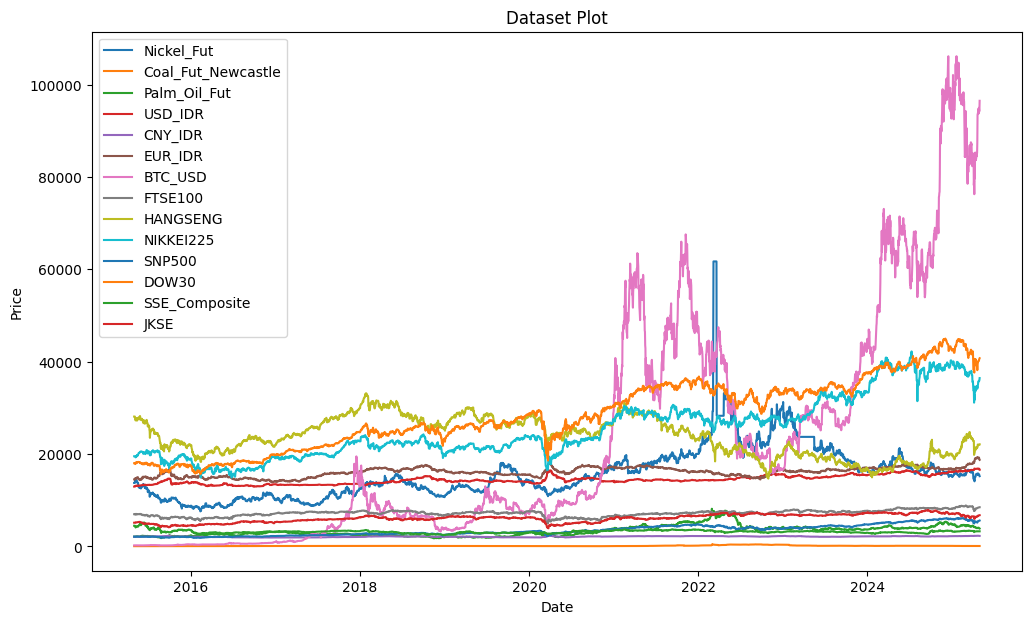

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [17]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
print(f"Feature columns: {feature_cols}")

Feature columns: ['Nickel_Fut', 'Coal_Fut_Newcastle', 'Palm_Oil_Fut', 'USD_IDR', 'CNY_IDR', 'EUR_IDR', 'BTC_USD', 'FTSE100', 'HANGSENG', 'NIKKEI225', 'SNP500', 'DOW30', 'SSE_Composite', 'JKSE']


In [18]:
# Scale X and y the same way you did before (train fit; transform val/test)
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])
    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32), np.array(idx_list)

LB = BEST_PARAMS["lookback"]
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, LB)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   LB)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  LB)

y_mean = float(y_scaler.mean_[0])
y_std  = float(np.sqrt(y_scaler.var_[0]))  # StandardScaler stores var_

In [19]:
# ==== 2) Evidential (NIG) utilities ============================================
# We use the NIG parameterization: (mu, v, alpha, beta)
# Predictive Student-t: dof = 2*alpha, loc = mu, scale^2 = beta * (1 + v) / (alpha * v)
# Variance decomposition on STANDARDIZED scale:
#   aleatoric_var  = beta / (alpha - 1)
#   epistemic_var  = beta / (v * (alpha - 1))
# For ORIGINAL scale, multiply variances by (y_std^2) and shift means by y_mean.

@tf.function
def softplus(x):  # numerically stable softplus
    return tf.nn.softplus(x)

def map_nig_params(raw_out):
    # raw_out [..., 4] -> (mu, v, alpha, beta) with positivity constraints
    m, v_raw, a_raw, b_raw = tf.unstack(raw_out, num=4, axis=-1)
    mu    = m
    v     = softplus(v_raw) + 1e-6
    alpha = softplus(a_raw) + 1.0 + 1e-6  # > 1
    beta  = softplus(b_raw) + 1e-6
    return mu, v, alpha, beta

@tf.function
def student_t_nll(y, mu, v, alpha, beta):
    # Predictive t params
    nu = 2.0 * alpha
    # scale^2 = beta * (1 + v) / (alpha * v)
    sigma2 = beta * (1.0 + v) / (alpha * v + 1e-12)
    sigma = tf.sqrt(sigma2 + 1e-12)

    # log pdf of Student-t
    # loglik = lgamma((nu+1)/2) - lgamma(nu/2) - 0.5*log(nu*pi) - log(sigma)
    #          - ((nu+1)/2)*log(1 + ((y-mu)^2)/(nu*sigma^2))
    c = tf.math.lgamma((nu + 1.0) * 0.5) - tf.math.lgamma(nu * 0.5)
    c -= 0.5 * (tf.math.log(nu) + tf.math.log(np.pi))
    c -= tf.math.log(sigma + 1e-12)

    sq = tf.square((y - mu) / (sigma + 1e-12))
    log_inner = tf.math.log1p(sq / (nu + 1e-12))
    loglik = c - 0.5 * (nu + 1.0) * log_inner
    return -tf.reduce_mean(loglik)

@tf.function
def evidential_regularizer(y, mu, v, alpha, beta):
    # Penalize unwarranted certainty when residuals are large
    # A common simple form: |y - mu| * (2*alpha + v)
    err = tf.abs(y - mu)
    penalty = err * (2.0 * alpha + v)
    return tf.reduce_mean(penalty)

def evidential_loss(y_true, y_pred):
    mu, v, alpha, beta = map_nig_params(y_pred)
    nll = student_t_nll(y_true, mu, v, alpha, beta)
    reg = evidential_regularizer(y_true, mu, v, alpha, beta)
    return nll + REG_LAMBDA * reg

In [20]:
# ==== 3) Build Evidential GRU using your best architecture =====================
def build_evidential_gru(n_features):
    model = Sequential()
    model.add(Input(shape=(LB, n_features)))
    if BEST_PARAMS["num_layers"] == 2:
        # (You optimized 1 layer, but keep pattern future-proof)
        model.add(GRU(BEST_PARAMS["units1"], return_sequences=True))
        model.add(Dropout(BEST_PARAMS["dropout"]))
        model.add(GRU(BEST_PARAMS["units2"]))
    else:
        model.add(GRU(BEST_PARAMS["units1"]))
    model.add(Dropout(BEST_PARAMS["dropout"]))
    model.add(Dense(4))  # raw heads: (m, v_raw, a_raw, b_raw)
    opt = optimizers.Adam(learning_rate=BEST_PARAMS["lr"])
    model.compile(optimizer=opt, loss=evidential_loss)
    return model

model = build_evidential_gru(n_features=len(feature_cols))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=BEST_PARAMS["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/gru_evidential_best.keras", monitor="val_loss", save_best_only=True)
]

print("\nTraining Evidential GRU...")
tic = time.time()
hist = model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=BEST_PARAMS["epochs"],
    batch_size=BEST_PARAMS["batch_size"],
    verbose=1,
    callbacks=callbacks
)
toc = time.time()
print(f"Training time: {toc - tic:.2f}s")


Training Evidential GRU...
Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.6215 - val_loss: -0.2807
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.3390 - val_loss: 0.0958
Epoch 3/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.5173 - val_loss: -0.6769
Epoch 4/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.6099 - val_loss: -1.1071
Epoch 5/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.8059 - val_loss: -1.0181
Epoch 6/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.9067 - val_loss: 0.1829
Epoch 7/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.8491 - val_loss: -1.2388
Epoch 8/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -0.9326 - val_loss: -1.2344
Epoch 9/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.9679 - val_loss: -1.2940
Epoch 10/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -0.9846 - val_loss: -1.1451
Epoch 11/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -1.0207 - val_loss: -0.9827
Epoch 12/40
82/8

In [21]:
# ==== 4) Predict heads -> params -> intervals on ORIGINAL scale ================
def predict_params(model, X, idx):
    raw = model.predict(X, verbose=0)
    mu, v, alpha, beta = map_nig_params(tf.convert_to_tensor(raw, dtype=tf.float32))
    # Convert to numpy
    mu   = mu.numpy()
    v    = v.numpy()
    alpha= alpha.numpy()
    beta = beta.numpy()

    # Predictive t params on STANDARDIZED scale
    nu = 2.0 * alpha
    sigma2_std = beta * (1.0 + v) / (alpha * v + 1e-12)
    sigma_std = np.sqrt(sigma2_std + 1e-12)

    # Convert to ORIGINAL scale:
    mu_orig = mu * y_std + y_mean
    sigma_orig = sigma_std * y_std

    # Aleatoric/Epistemic variances (standardized) -> original
    ale_std = beta / (alpha - 1.0 + 1e-12)
    epi_std = beta / (v * (alpha - 1.0) + 1e-12)
    ale_orig = ale_std * (y_std ** 2)
    epi_orig = epi_std * (y_std ** 2)

    return (pd.Series(mu_orig, index=idx, name="mu"),
            pd.Series(nu, index=idx, name="nu"),
            pd.Series(sigma_orig, index=idx, name="sigma"),
            pd.Series(ale_orig, index=idx, name="ale_var"),
            pd.Series(epi_orig, index=idx, name="epi_var"))

from scipy.stats import t as student_t

def make_pi(mu_s, nu_s, sigma_s, alpha_ci=0.05):
    # Two-sided quantiles from Student-t with dof=nu
    q = student_t.ppf(1.0 - alpha_ci/2.0, df=nu_s.values)
    lower = mu_s.values - q * sigma_s.values
    upper = mu_s.values + q * sigma_s.values
    return pd.Series(lower, index=mu_s.index, name="L"), pd.Series(upper, index=mu_s.index, name="U")

# Train/Val/Test params
mu_tr, nu_tr, sig_tr, ale_tr, epi_tr = predict_params(model, X_train_w, idx_train)
mu_va, nu_va, sig_va, ale_va, epi_va = predict_params(model, X_val_w,   idx_val)
mu_te, nu_te, sig_te, ale_te, epi_te = predict_params(model, X_test_w,  idx_test)

L_tr, U_tr = make_pi(mu_tr, nu_tr, sig_tr, ALPHA_CI)
L_va, U_va = make_pi(mu_va, nu_va, sig_va, ALPHA_CI)
L_te, U_te = make_pi(mu_te, nu_te, sig_te, ALPHA_CI)

In [22]:
# ==== 5) Metrics (original scale) ==============================================
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

def base_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, mae, rmse, mape, r2

def interval_metrics(y_true, L, U, alpha_ci=0.05):
    y = y_true.values
    Lv, Uv = L.values, U.values
    covered = (y >= Lv) & (y <= Uv)
    picp = covered.mean()
    mpiw = np.mean(Uv - Lv)
    # Winkler
    alpha = alpha_ci
    W = np.where(
        covered,
        (Uv - Lv),
        np.where(y < Lv, (Uv - Lv) + (2.0/alpha)*(Lv - y),
                 (Uv - Lv) + (2.0/alpha)*(y - Uv))
    )
    winkler = np.mean(W)
    return picp, mpiw, winkler, pd.Series(covered.astype(int), index=y_true.index, name="Covered")

m_train = base_metrics(actual_train, mu_tr)
m_val   = base_metrics(actual_val,   mu_va)
m_test  = base_metrics(actual_test,  mu_te)

picp_tr, mpiw_tr, wink_tr, covered_tr = interval_metrics(actual_train, L_tr, U_tr, ALPHA_CI)
picp_va, mpiw_va, wink_va, covered_va = interval_metrics(actual_val,   L_va, U_va, ALPHA_CI)
picp_te, mpiw_te, wink_te, covered_te = interval_metrics(actual_test,  L_te, U_te, ALPHA_CI)

metrics_df = pd.DataFrame(
    [
        [*m_train, picp_tr, mpiw_tr, wink_tr],
        [*m_val,   picp_va, mpiw_va, wink_va],
        [*m_test,  picp_te, mpiw_te, wink_te],
    ],
    columns=["MSE","MAE","RMSE","MAPE","R²","PICP","MPIW","Winkler"],
    index=["Train","Validation","Test"]
)
pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary — Evidential GRU (Student-t predictive) ===")
print(metrics_df)



=== Metrics Summary — Evidential GRU (Student-t predictive) ===
                  MSE      MAE     RMSE   MAPE     R²   PICP     MPIW  \
Train       2170.3396  31.3899  46.5869 0.0056 0.9957 0.9754 253.8963   
Validation  2250.9839  35.7806  47.4445 0.0051 0.9169 0.9809 238.3503   
Test       19294.1151 122.1160 138.9033 0.0171 0.8288 0.2300 120.2835   

             Winkler  
Train       292.6760  
Validation  254.3175  
Test       2878.8931  


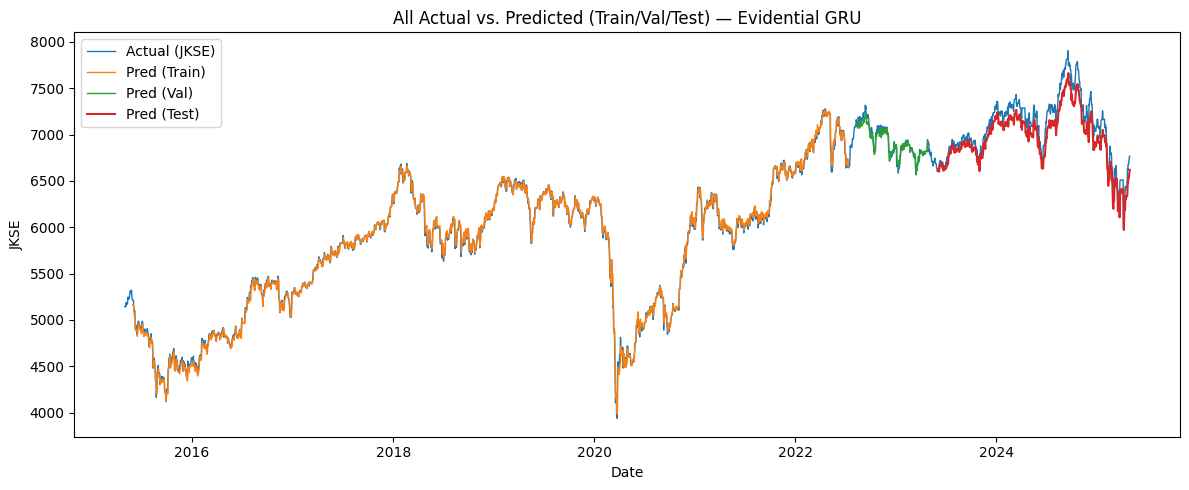

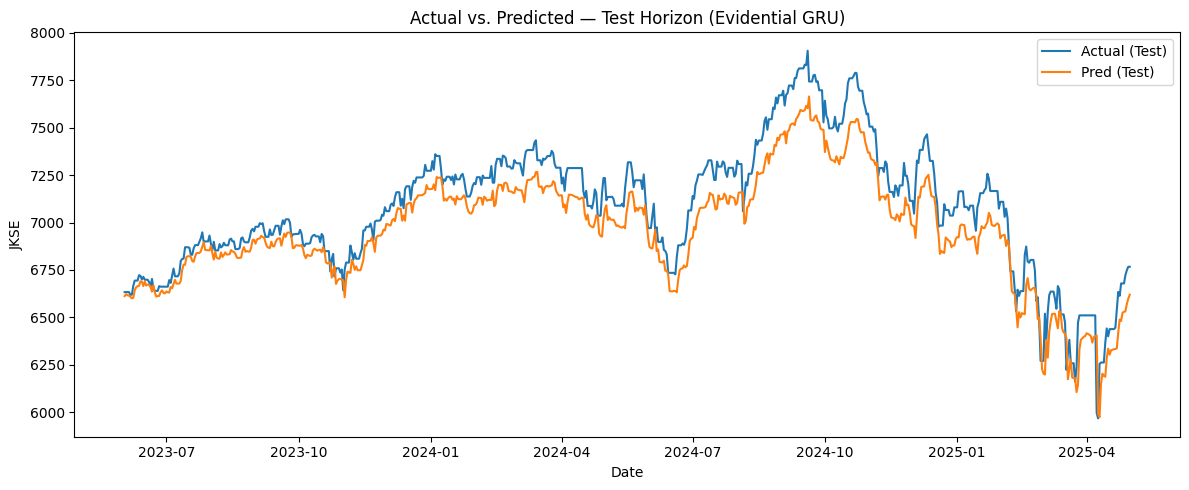

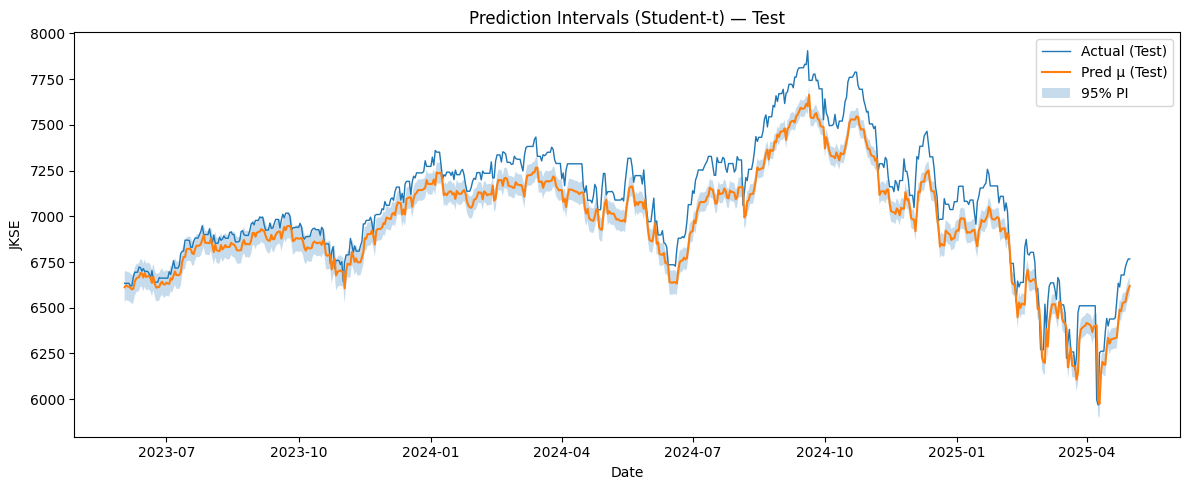

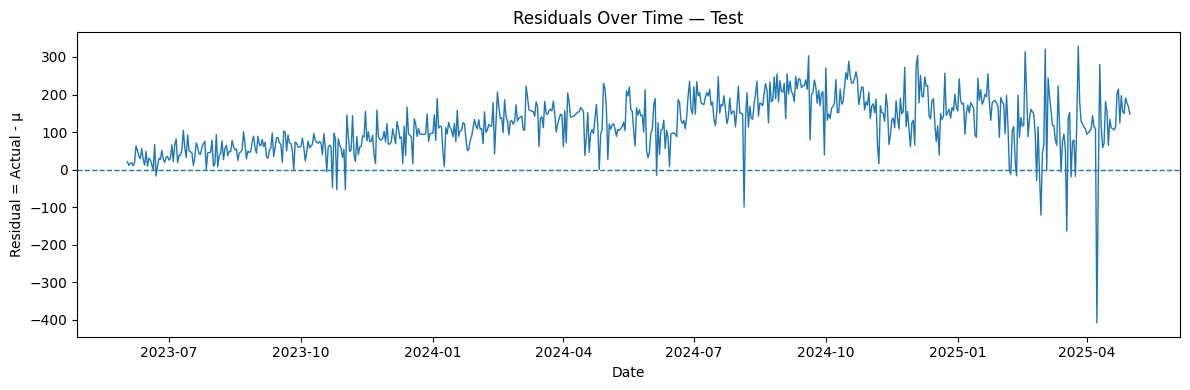

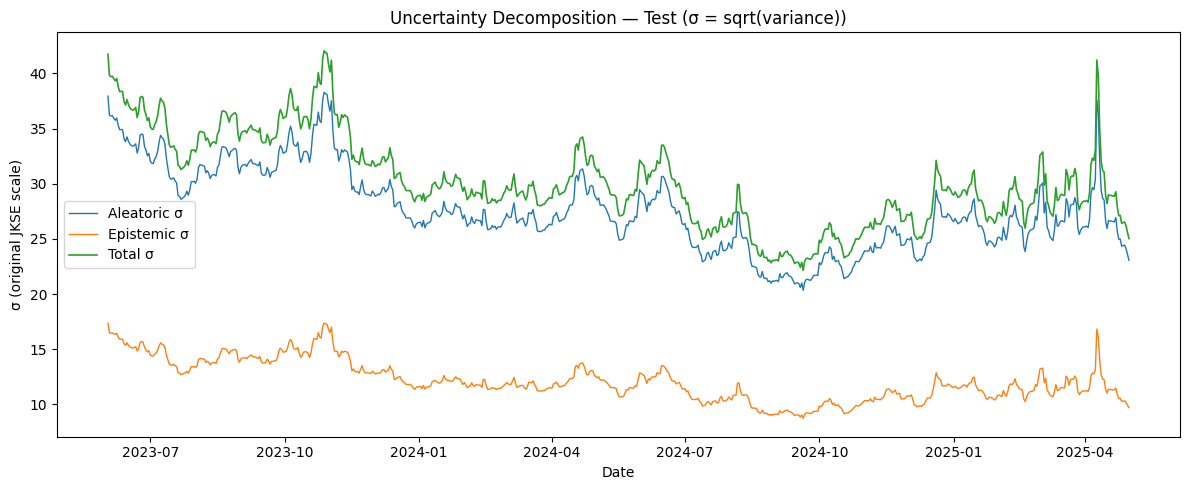

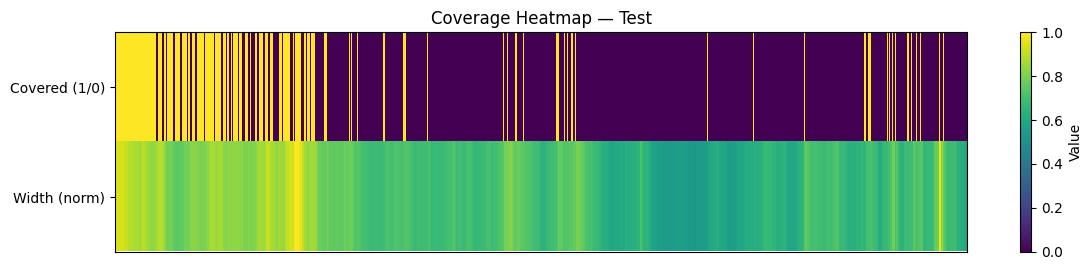

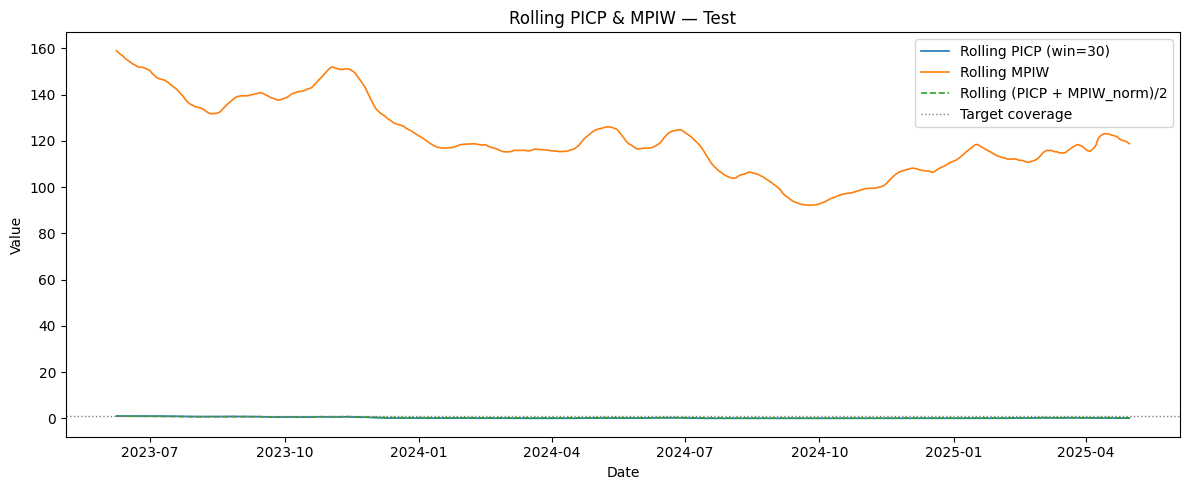

In [23]:
# ==== 6) Visualizations =========================================================
# (1) All data vs predict train/val/test
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(mu_tr.index, mu_tr.values, label="Pred (Train)", linewidth=1)
plt.plot(mu_va.index, mu_va.values, label="Pred (Val)", linewidth=1)
plt.plot(mu_te.index, mu_te.values, label="Pred (Test)", linewidth=1.5)
plt.title("All Actual vs. Predicted (Train/Val/Test) — Evidential GRU")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (2) Only actual vs test predicted
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mu_te.index,      mu_te.values,      label="Pred (Test)", linewidth=1.5)
plt.title("Actual vs. Predicted — Test Horizon (Evidential GRU)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (3) Prediction with UQ band/interval (Test)
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1)
plt.plot(mu_te.index, mu_te.values, label="Pred μ (Test)", linewidth=1.5)
plt.fill_between(mu_te.index, L_te.values, U_te.values, alpha=0.25, label=f"{int((1-ALPHA_CI)*100)}% PI")
plt.title("Prediction Intervals (Student-t) — Test")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (4) Residuals over time (Test)
resid_te = pd.Series(actual_test.values - mu_te.values, index=actual_test.index, name="Residual")
plt.figure(figsize=(12,4))
plt.plot(resid_te.index, resid_te.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time — Test")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - μ")
plt.tight_layout(); plt.show()

# (5) Uncertainty decomposition over time (Test)
total_var_te = ale_te + epi_te
plt.figure(figsize=(12,5))
plt.plot(ale_te.index, np.sqrt(ale_te.values), label="Aleatoric σ", linewidth=1)
plt.plot(epi_te.index, np.sqrt(epi_te.values), label="Epistemic σ", linewidth=1)
plt.plot(total_var_te.index, np.sqrt(total_var_te.values), label="Total σ", linewidth=1.2)
plt.title("Uncertainty Decomposition — Test (σ = sqrt(variance))")
plt.xlabel("Date"); plt.ylabel("σ (original JKSE scale)")
plt.legend(); plt.tight_layout(); plt.show()

# (6) Coverage heatmap (Test) : 1 if covered else 0
# Simple 2-row heatmap: top = coverage, bottom = normalized width
cov_mat = np.vstack([
    covered_te.values, 
    ((U_te - L_te) / (U_te - L_te).max()).values
])
plt.figure(figsize=(12,2.8))
plt.imshow(cov_mat, aspect='auto', cmap='viridis', interpolation='nearest')
plt.yticks([0,1], ["Covered (1/0)","Width (norm)"])
plt.xticks([])
plt.colorbar(label="Value")
plt.title("Coverage Heatmap — Test")
plt.tight_layout(); plt.show()

# (7) Rolling PICP, MPIW, and normalized (PICP + MPIW)
def rolling_mean(series, win):
    return series.rolling(win, min_periods=max(5, win//4)).mean()

cov_series = covered_te.astype(float)
width_series = (U_te - L_te)

plt.figure(figsize=(12,5))
plt.plot(rolling_mean(cov_series, ROLL_WIN), label=f"Rolling PICP (win={ROLL_WIN})", linewidth=1.2)
plt.plot(rolling_mean(width_series, ROLL_WIN), label="Rolling MPIW", linewidth=1.2)
# Normalize to [0,1] for a joint trend plot
picp_norm = rolling_mean(cov_series, ROLL_WIN)  # already 0..1
mpiw_norm = (rolling_mean(width_series, ROLL_WIN) - width_series.min()) / (width_series.max()-width_series.min() + 1e-12)
plt.plot((picp_norm + mpiw_norm)/2.0, label="Rolling (PICP + MPIW_norm)/2", linewidth=1.2, linestyle="--")
plt.axhline(1.0-ALPHA_CI, color='gray', linestyle=':', linewidth=1, label="Target coverage")
plt.title("Rolling PICP & MPIW — Test")
plt.xlabel("Date"); plt.ylabel("Value")
plt.legend(); plt.tight_layout(); plt.show()


Calibration (Test):
   Nominal  Empirical  MeanWidth
0   0.5000     0.0586    38.0150
1   0.6800     0.0871    56.7899
2   0.8000     0.1129    74.3817
3   0.9000     0.1800    98.0553
4   0.9500     0.2300   120.2835


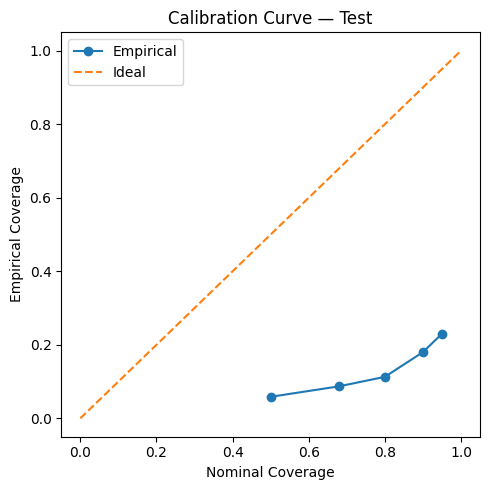

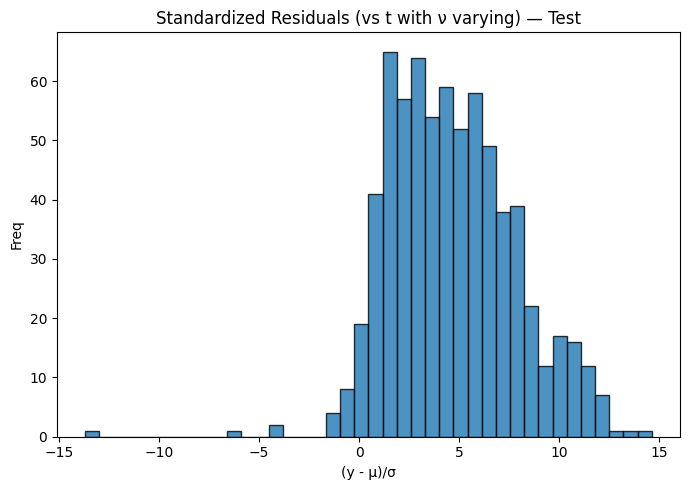

In [24]:
# ==== 7) (Optional) Extra diagnostics to strengthen your discussion =============
# A) Calibration curve: empirical coverage vs nominal (using multiple nominal levels)
def empirical_coverage(mu, nu, sigma, y, levels=(0.50, 0.8, 0.9, 0.95, 0.98)):
    rows = []
    for lev in levels:
        q = student_t.ppf(1-(1-lev)/2, df=nu.values)
        L = mu.values - q*sigma.values
        U = mu.values + q*sigma.values
        cov = ((y.values >= L) & (y.values <= U)).mean()
        rows.append((lev, cov, np.mean(U-L)))
    return pd.DataFrame(rows, columns=["Nominal","Empirical","MeanWidth"])

calib_df = empirical_coverage(mu_te, nu_te, sig_te, actual_test, levels=(0.5,0.68,0.8,0.9,0.95))
print("\nCalibration (Test):")
print(calib_df)

plt.figure(figsize=(5,5))
plt.plot(calib_df["Nominal"], calib_df["Empirical"], marker="o", label="Empirical")
plt.plot([0,1],[0,1], linestyle="--", label="Ideal")
plt.xlabel("Nominal Coverage"); plt.ylabel("Empirical Coverage")
plt.title("Calibration Curve — Test")
plt.legend(); plt.tight_layout(); plt.show()

# B) Standardized residuals QQ-like check (y - mu) / sigma
std_resid = (actual_test.values - mu_te.values) / (sig_te.values + 1e-12)
plt.figure(figsize=(7,5))
plt.hist(std_resid, bins=40, edgecolor="black", alpha=0.8)
plt.title("Standardized Residuals (vs t with ν varying) — Test")
plt.xlabel("(y - μ)/σ"); plt.ylabel("Freq")
plt.tight_layout(); plt.show()